# Modèle : Random Forest

In [30]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import random
import sys
from collections import Counter
from sklearn.model_selection import train_test_split

# selection des caractéristiques
import eli5
from eli5.sklearn import PermutationImportance

# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

## Préparation des données

### On récupère les données

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
# vérification des valeurs manquantes
train_data.isna().any(axis=1).sum() 

0

In [50]:
np.random.seed(0)
train_data.sample(3)

,SNo,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,...,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
9899,9900,23.820078,277.1875,47.176041,-4.729332,0.406940,-7.057485,-0.912706,0.019451,101389.7969,...,218.150177,266.794098,1.560000e-09,303.172699,302.206573,123.387115,12435.69043,66.750351,20040819,0
33519,33520,24.054759,277.8125,13.870062,1.498383,-5.639065,1.640853,-4.943167,0.008095,102034.5313,...,215.639481,259.628265,1.010000e-15,297.291992,292.712280,172.767990,12140.54688,64.161621,20000106,0
31801,31802,-24.993481,242.5000,34.492935,2.140951,-1.965367,0.902226,-1.249496,0.013912,101743.2813,...,215.697800,265.288055,3.320000e-08,295.071472,293.564972,149.596268,12303.84473,64.662750,20000928,2


In [52]:
def plot_pie_chart(effectif):
    effectifs = effectif.values
    labels = effectif.index.astype(str)

    # graphique
    plt.pie(effectifs, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Effectifs par classe')
    plt.show()


In [53]:
effectif = train_data['Label'].value_counts()
effectif

Label
0    35179
2     7756
1     1825
Name: count, dtype: int64

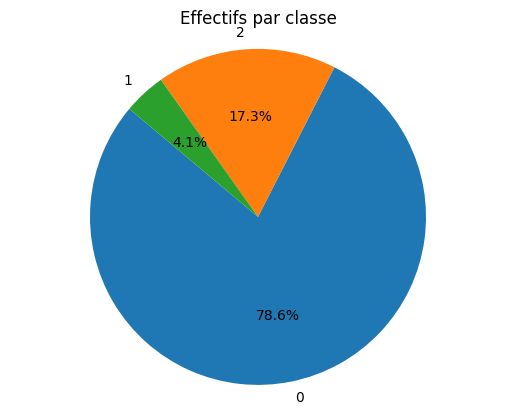

In [54]:
plot_pie_chart(effectif)

Le jeu de données est fortement déséquilibré car la classe 0 prédomine largement sur les autres. On va donc devoir trouver une solution à ce problème.

### Standardisation des données

In [55]:
def standardize_data(X):
    # calcul de la moyenne et l'écart-type pour chaque caractéristique
    means = np.mean(X, axis=0)
    std_devs = np.std(X, axis=0)

    # standardisation 
    standardized_X = (X - means) / std_devs

    return standardized_X

In [56]:
train_data_standard = train_data.copy()
train_data_standard.iloc[:,1:-1] = standardize_data(train_data_standard.iloc[:,1:-1])

### Sélection des caractéristiques

In [5]:
print(train_data.columns)
print(train_data.columns.size)

Index(['SNo', 'lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
       'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200',
       'ZBOT', 'time', 'Label'],
      dtype='object')
21


In [6]:
train_data.dtypes

SNo         int64
lat       float64
lon       float64
TMQ       float64
U850      float64
V850      float64
UBOT      float64
VBOT      float64
QREFHT    float64
PS        float64
PSL       float64
T200      float64
T500      float64
PRECT     float64
TS        float64
TREFHT    float64
Z1000     float64
Z200      float64
ZBOT      float64
time        int64
Label       int64
dtype: object

Il y a beaucoup de caractéristiques et on va chercher les plus importantes pour nos prédictions.

In [8]:
X_train_select, X_val_select, y_train_select, y_val_select = split_data(train_data, "Label")

In [9]:
model = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model.fit(X_train_select.iloc[:,1:], y_train_select)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [14]:
y_pred = model.predict(X_val_select.iloc[:,1:])
accuracy = accuracy_score(y_val_select, y_pred)
print(accuracy)
classif_report = classification_report(y_val_select, y_pred)
print(classif_report)

0.8840482573726541
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7069
           1       0.80      0.49      0.61       364
           2       0.78      0.64      0.70      1519

    accuracy                           0.88      8952
   macro avg       0.83      0.70      0.75      8952
weighted avg       0.88      0.88      0.88      8952



In [17]:
perm = PermutationImportance(model).fit(X_val_select.iloc[:,1:], y_val_select)

In [18]:
eli5.show_weights(perm, feature_names = X_val_select.iloc[:,1:].columns.tolist())

Weight,Feature
0.0392 ± 0.0043,lat
0.0248 ± 0.0034,U850
0.0102 ± 0.0009,TMQ
0.0078 ± 0.0029,Z200
0.0055 ± 0.0014,TS
0.0054 ± 0.0020,time
0.0034 ± 0.0014,lon
0.0033 ± 0.0014,UBOT
0.0028 ± 0.0010,TREFHT
0.0025 ± 0.0011,VBOT


"lat", "U850", "TMQ", "Z200" semblent être les caractéristiques avec le plus d'influence sur la prédiction.

In [26]:
features = ["lat", "U850", "TMQ", "Z200", "TS", "time"] # , "lon", "UBOT"]

In [27]:
model_select_features = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model_select_features.fit(X_train_select[features], y_train_select)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [28]:
y_pred = model_select_features.predict(X_val_select[features])
accuracy = accuracy_score(y_val_select, y_pred)
print(accuracy)
classif_report = classification_report(y_val_select, y_pred)
print(classif_report)

0.8783512064343163
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7069
           1       0.79      0.42      0.55       364
           2       0.79      0.60      0.68      1519

    accuracy                           0.88      8952
   macro avg       0.82      0.66      0.72      8952
weighted avg       0.87      0.88      0.87      8952



Le résultat ne semble pas meilleur.

### Oversampling

Pour rappel, voici le compte des éléments des différentes classes :

In [21]:
train_data['Label'].value_counts()

Label
0    35179
2     7756
1     1825
Name: count, dtype: int64

On équilibre partiellement les classes

In [58]:
# classes majoritaire et minoritaires des données
X_majority = train_data.iloc[:,1:-1][train_data.iloc[:,-1] == 0]
X_minority1 = train_data.iloc[:,1:-1][train_data.iloc[:,-1] == 1]
X_minority2 = train_data.iloc[:,1:-1][train_data.iloc[:,-1] == 2]

# nb de données pour chaque classe minoritaire
oversample_amount = 10000  

# échantillonnage aléatoire avec remplacement pour chaque classe minoritaire
X_minority1_oversampled = resample(X_minority1, n_samples=oversample_amount, random_state=42)
X_minority2_oversampled = resample(X_minority2, n_samples=oversample_amount, random_state=42)

# on concatène pour reformer le jeu de données
X_resampled = np.vstack([X_majority, X_minority1_oversampled, X_minority2_oversampled])
y_resampled = np.concatenate([train_data.iloc[:,-1][train_data.iloc[:,-1] == 0], np.ones(oversample_amount, dtype=int), 2*np.ones(oversample_amount, dtype=int)])

print(pd.Series(y_resampled).value_counts())


0    35179
1    10000
2    10000
Name: count, dtype: int64


In [60]:
# on crée un DataFrame à partir de X_over et de y_over afin d'obtenir un dataframe final des données équilibrées
X_over2_df = pd.DataFrame(X_resampled, columns=train_data.drop(['Label', 'SNo'], axis='columns').columns)
y_over2_df = pd.DataFrame(y_resampled, columns=['Label'])

train_data_over2 = pd.concat([X_over2_df, y_over2_df], axis=1)

On équilibre totalement les classes

In [15]:
# on équilibre les données avec la méthode SMOTE
X_over, y_over = SMOTE().fit_resample(train_data.drop('Label', axis='columns'), train_data['Label'])

In [16]:
Counter(y_over)

Counter({1: 35179, 2: 35179, 0: 35179})

In [17]:
# de meme on fait un dataframe
X_over_df = pd.DataFrame(X_over, columns=train_data.drop('Label', axis='columns').columns)
y_over_df = pd.DataFrame(y_over, columns=['Label'])

train_data_over = pd.concat([X_over_df, y_over_df], axis=1)

In [19]:
train_data_over.head(3)

,SNo,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,...,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,1,21.707953,275.0,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,...,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
1,2,21.707953,275.0,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,...,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
2,3,21.473272,275.0,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,...,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1


### Séparation du jeu de données en train/validation

In [68]:
# on sépare l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = split_data(train_data, "Label")
X_train_standard, X_val_standard, y_train_standard, y_val_standard = split_data(train_data_standard, "Label")
X_train_over, X_val_over, y_train_over, y_val_over = split_data(train_data_over, "Label")
X_train_over2, X_val_over2, y_train_over2, y_val_over2 = split_data(train_data_over2, "Label")

### Recherche des meilleurs hyperparamètres

Source : https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv

In [61]:
def optim_random_forest(X_train, y_train):
    model = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, 30, 40, None]  # None signifie qu'il n'y a pas de limite de profondeur
    }

    # cross validation pour rechercher les meilleures combinaisons d'hyperparamètres
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # meilleurs hyperparamètres
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_max_depth = grid_search.best_params_['max_depth']

    return best_n_estimators, best_max_depth

# décommenter les prochaines lignes pour executer l'optimisation des hyperparamètres
#best_n_estimators, best_max_depth = optim_random_forest(train_data.iloc[:,1:-1], train_data.iloc[:,-1])
#print(f"Meilleurs hyperparamètres - n_estimators : {best_n_estimators}, max_depth : {best_max_depth}")


Meilleurs hyperparamètres - n_estimators : 300, max_depth : 10

### Entrainement

In [22]:
model = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model.fit(train_data.iloc[:,1:-1], train_data.iloc[:,-1])

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

### Prédictions

In [23]:
pred = model.predict(test_data.iloc[:,1:])
pred

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

In [24]:
Counter(pred)

Counter({0: 8729, 2: 1284, 1: 307})

In [28]:
preds = pd.DataFrame(pred)

In [29]:
sno = test_data.iloc[:,0]
new = pd.concat([sno, preds], axis = 1)
new.sample(5)

,SNo,0
8161,8162,0
4033,4034,0
8468,8469,0
8403,8404,0
8626,8627,0


In [48]:
# save the predictions
# new.to_csv('submit/submit_8_rdm_forest_opti.csv', index=False)

Entraînement et évaluation d'un modèle

Données brutes : 

In [30]:
model = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model.fit(X_train.iloc[:,1:], y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [31]:
pred = model.predict(X_val.iloc[:,1:])
pred

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
accuracy = accuracy_score(y_val, pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8840482573726541


Données standardisées : 

In [74]:
model_standard = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model_standard.fit(X_train_standard.iloc[:,1:], y_train_standard)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [75]:
pred_standard = model.predict(X_val_standard.iloc[:,1:])
pred_standard

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
accuracy_standard = accuracy_score(y_val_standard, pred_standard)

print(f"Accuracy: {accuracy_standard}")

Accuracy: 0.7896559428060769


Avec sur-échantillonnage

In [65]:
model_over2 = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model_over2.fit(X_train_over2.iloc[:,1:], y_train_over2) # sur échantillonnage partiel

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [66]:
pred2 = model_over2.predict(X_val_over2.iloc[:,1:])
pred2

array([0, 0, 2, ..., 0, 0, 1], dtype=int64)

In [67]:
accuracy2 = accuracy_score(y_val_over2, pred2)

print(f"Accuracy: {accuracy2}")

Accuracy: 0.8967017035157666


In [33]:
model_over = RandomForestClassifier(n_estimators = 300, max_depth=10, random_state=0)
model_over.fit(X_train_over.iloc[:,1:], y_train_over) # sur échantillonnage total

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [34]:
pred = model_over.predict(X_val_over.iloc[:,1:])
pred

array([2, 2, 0, ..., 1, 1, 2], dtype=int64)

In [35]:
accuracy = accuracy_score(y_val_over, pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.908423346598446


In [36]:
pred = model_over.predict(test_data.iloc[:,1:])
preds = pd.DataFrame(pred)
sno = test_data.iloc[:,0]
new = pd.concat([sno, preds], axis = 1)
new.sample(5)

,SNo,0
2747,2748,1
6679,6680,2
7621,7622,0
851,852,0
7054,7055,0


In [37]:
preds.value_counts()

0    5513
2    2814
1    1993
Name: count, dtype: int64

In [111]:
# save the predictions
# new.to_csv('submit/submit_9_rdm_forest_opti_over.csv', index=False)